# o'reillyのネゴザメ言語モデルの本

## 文字列のベクトル化（３）
推論ベースの手法 > 文脈予測アプローチの高速化

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インストール](#インストール)
  - [インポート](#インポート)
- 推論ベースの手法 > 文脈予測アプローチの高速化
  - [モデルの定義](#モデルの定義)
    - [NegativeSamplingLoss](#NegativeSamplingLoss)
    - [CBOW（Embedding&NegativeSamplingLoss）](#CBOW（Embedding&NegativeSamplingLoss）)
    - [Skip-gram（Embedding&NegativeSamplingLoss）](#Skip-gram（Embedding&NegativeSamplingLoss）)
  - [モデルの実行](#モデルの実行)
    - [モデルの学習](#モデルの学習)
    - [分散表現の評価](#分散表現の評価)
    
## 参考
- https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master/ch04
- [言語処理（AI）> ベクトル化 - 開発基盤部会 Wiki](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86%EF%BC%88AI%EF%BC%89#k2009143) > [推論ベースの手法 > 文脈予測アプローチ](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86%EF%BC%88AI%EF%BC%89#t6fb7c98)

## 環境準備

### インストール

In [ ]:
!pip install numpy
!pip install matplotlib

### インポート

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定

## 推論ベースの手法 > 文脈予測アプローチの高速化
CBOW＆Negative Sampling の word2vec  
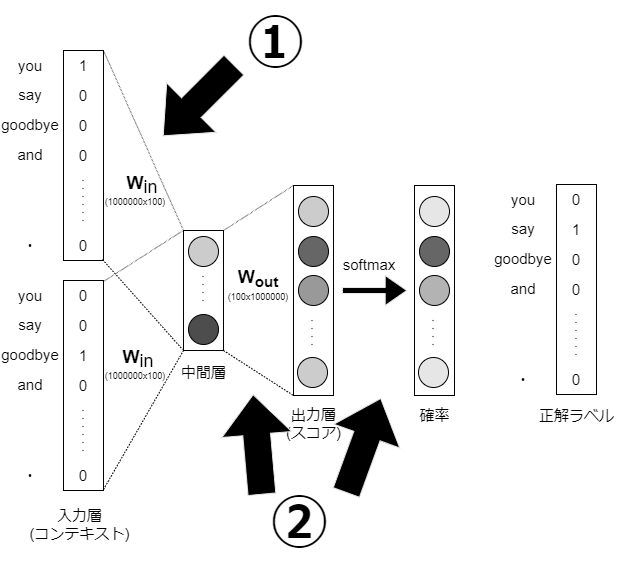
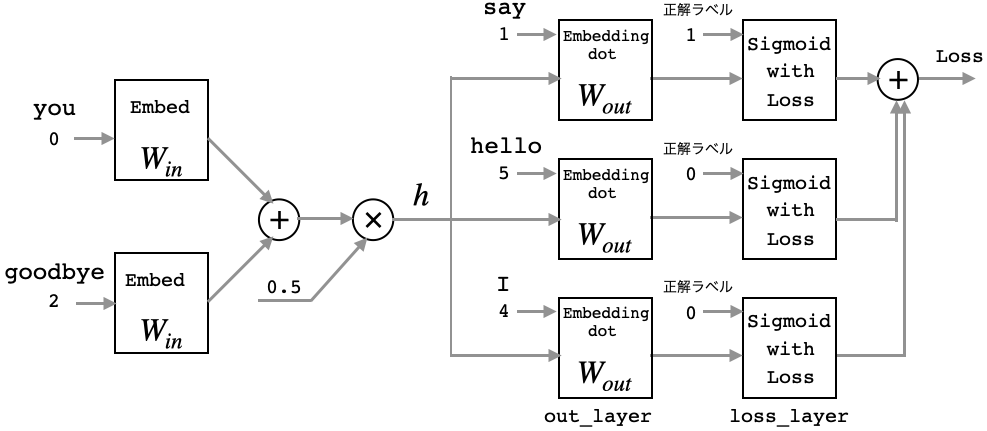

### モデルの定義

In [ ]:
from nekozame.common.np import *  # import numpy as np
from nekozame.common.layers import Embedding, SigmoidWithLoss
import collections

#### NegativeSamplingLoss
NegativeSamplingLossの損失関数の定義

##### EmbeddingDot
EmbeddingDotは出力側のMatMulレイヤをEmbeddingレイヤに変更したもの。

In [ ]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

##### UnigramSampler
UnigramSamplerは負例のサンプリングを行うクラスらしい。

In [ ]:
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

##### NegativeSamplingLoss
定義したクラスを用い、NegativeSamplingLossの損失関数を定義。

In [ ]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

#### CBOW（Embedding&NegativeSamplingLoss）
定義したクラスを用い、改良版のCBOWを定義。

In [ ]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # すべての重みと勾配をリストにまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

#### Skip-gram（Embedding&NegativeSamplingLoss）
定義したクラスを用い、改良版のSkip-gramを定義。

In [ ]:
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # レイヤの生成
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None

### モデルの実行

#### 学習
- 以下コードは遅いので、コメントアウト
- 次の[重み（分散表現）のロード](#重み（分散表現）のロード)から再開できます。

```Python
from nekozame.common import config
# GPUで実行する場合は、下記のコメントアウトを消去（要cupy）
# ===============================================
# config.GPU = True
# ===============================================
import pickle
from nekozame.common.trainer import Trainer
from nekozame.common.optimizer import Adam
from nekozame.common.util import create_contexts_target, to_cpu, to_gpu
from nekozame.dataset import ptb

# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = '../work/cbow_params.pkl' # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)
```

#### 分散表現の評価

In [ ]:
from nekozame.common.util import most_similar, analogy
import pickle

##### 重み（分散表現）のロード

In [ ]:
pkl_file = '../work/cbow_params.pkl' # or 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

##### 類似単語ランキング
most similar task

In [ ]:
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

##### 加法構成性の確認
analogy task

In [ ]:
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)